In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import time

In [2]:
dataset = pd.read_csv('new_appdata10.csv')

# DATA PRE-PROCESSING

In [3]:
response = dataset["enrolled"]
dataset = dataset.drop(columns="enrolled")

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, response, test_size = 0.2, random_state = 0)

In [5]:
train_identity = X_train['user']
X_train = X_train.drop(columns = ['user'])
test_identity = X_test['user']
X_test = X_test.drop(columns = ['user'])

In [6]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_test2 = pd.DataFrame(sc_X.transform(X_test))
X_train2.columns = X_train.columns.values
X_test2.columns = X_test.columns.values
X_train2.index = X_train.index.values
X_test2.index = X_test.index.values
X_train = X_train2
X_test = X_test2

# MODEL BUILDING 

In [7]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0, penalty = 'l1', solver='liblinear')
classifier.fit(X_train, y_train)

LogisticRegression(penalty='l1', random_state=0, solver='liblinear')

In [8]:
y_pred = classifier.predict(X_test)

Test Data Accuracy: 0.7681


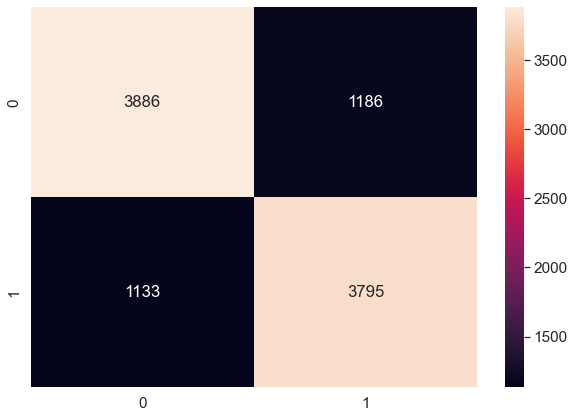

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
cm = confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred)
precision_score(y_test, y_pred) # tp / (tp + fp)
recall_score(y_test, y_pred) # tp / (tp + fn)
f1_score(y_test, y_pred)

df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))

In [10]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("SVM Accuracy: %0.3f (+/- %0.3f)" % (accuracies.mean(), accuracies.std() * 2))

SVM Accuracy: 0.767 (+/- 0.009)


# FORMATTING THE FINAL RESULTS

In [11]:
pd.concat([pd.DataFrame(dataset.drop(columns = 'user').columns, columns = ["features"]), pd.DataFrame(np.transpose(classifier.coef_), columns = ["coef"])],axis = 1)

,features,coef
0,dayofweek,0.032572
1,hour,-0.003604
2,age,-0.149679
3,numscreens,-0.130627
4,minigame,-0.026464
5,used_premium_feature,-0.065915
6,liked,0.010692
7,location,-0.028322
8,Institutions,-0.062202
9,VerifyPhone,0.650363


In [12]:
from sklearn.model_selection import GridSearchCV
penalty = ['l1', 'l2']
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]


In [13]:
parameters = dict(C=C, penalty=penalty)

In [14]:
grid_search = GridSearchCV(estimator = classifier, param_grid = parameters, scoring = "accuracy", cv = 10, n_jobs = -1)

In [15]:
t0 = time.time()

In [17]:
grid_search = grid_search.fit(X_train, y_train)

In [18]:
t1 = time.time()

In [19]:
print("Took %0.2f seconds" % (t1 - t0))

Took 84.69 seconds


In [20]:
rf_best_accuracy = grid_search.best_score_
rf_best_parameters = grid_search.best_params_
rf_best_accuracy, rf_best_parameters

(0.76735, {'C': 0.01, 'penalty': 'l2'})

In [21]:
grid_search.best_score_

0.76735

In [22]:
final_results = pd.concat([y_test, test_identity], axis = 1).dropna()
final_results['predicted_reach'] = y_pred
final_results = final_results[['user', 'enrolled', 'predicted_reach']].reset_index(drop=True)

In [23]:
final_results

,user,enrolled,predicted_reach
0,239786,1,1
1,279644,1,1
2,98290,0,0
3,170150,1,1
4,237568,1,1
...,...,...,...
9995,143036,1,0
9996,91158,1,1
9997,248318,0,0
9998,142418,1,1
